In [11]:
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import plotly.io as pio
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples


pio.renderers.default = "colab"

In [2]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Read the uploaded CSV file
for file_name in uploaded.keys():
    df = pd.read_csv(file_name)
    print("File", file_name, "uploaded successfully!")

Saving Mall_Customers.csv to Mall_Customers (1).csv
File Mall_Customers (1).csv uploaded successfully!


# Business Goal
To help a supermarket boost their membership card sign-up rate, I'll delve into various clustering methods to conduct a customer segmentation analysis. Customer segmentation involves identifying similar customer groups based on shared traits such as shopping habits and buying patterns, enabling companies to tailor marketing efforts more efficiently to each group. This notebook will entail building several clustering models to gain insights into the store's customer demographics and to devise tactics aimed at boosting membership sign-ups. The methods explored will include K-Means Clustering, Hierarchical Clustering, and DBSCAN.

# In this notebook we understand how effective methods for clustering can be performed to carry out customer segmentation for the customers of a supermall.

# Index


1.   Data Description - Mall customers with 4 features
2.   Data statistics summary    
3.   Exploratory Data Analysis
4.   Box plots , Correlation plots - Conclusions
5.   Summary of Exploratory Data Analysis
6.   K - Means Clustering
###### -   Interntia and Silhouette diagram methods to reach optimal K value
###### -  Clustering visualization with dimentionality reduction using PCA

7. Clustering with Gaussian Mixture Models
###### -   Deciding optimal number of clusters with AIC and BIC curves
###### -  Clustering visualization with dimentionality reduction using PCA


8. Clustering with DBSCAN
###### -   Deciding optimal number of clusters with DBSCAN algorithm
###### -  Clustering visualization with dimentionality reduction using PCA

9. Generating new data with GMMs

10. Label prediction and classification of new customers into segments










# Data Description


In [3]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [4]:
df.info()

print("There are {} instances and {} columns in the data set.".format(df.shape[0], df.shape[1]))
print("There are {} missing values in the dataset".format(df.isna().sum().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
There are 200 instances and 5 columns in the data set.
There are 0 missing values in the dataset


# Data Statistics summary

In [5]:
df.drop('CustomerID', axis = 1, inplace = True)
df.describe()


,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## Data Statistic summary for catagorical variable

In [6]:
df['Gender'] = ['Women' if i == 'Female'else 'Men' for i in df.Gender]
df.Gender.describe().T

count       200
unique        2
top       Women
freq        112
Name: Gender, dtype: object

# Exploratory Data Analysis

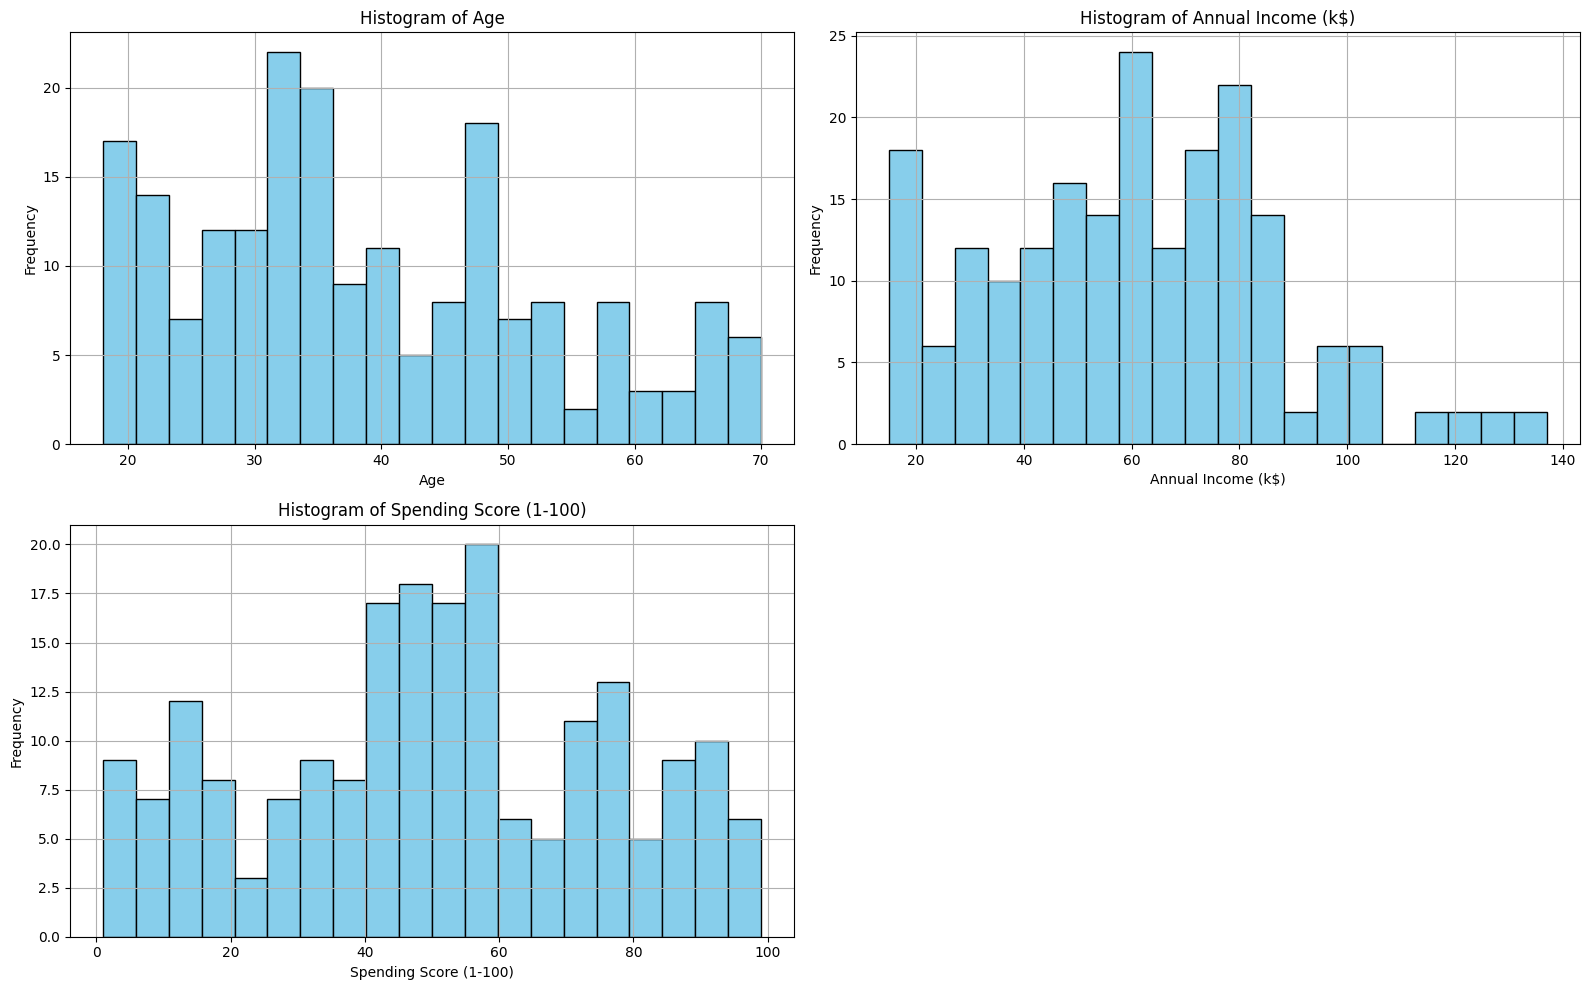

In [7]:

# Get all columns except the first one (assuming the first column is not a feature)
columns_to_plot = df.columns[1:]

# Calculate number of rows and columns needed for subplots
num_cols = len(columns_to_plot)
num_rows = (num_cols + 1) // 2  # Add 1 and then divide to ensure rounding up

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(16, num_rows * 5))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot histograms for each column
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Hide unused subplots
for i in range(num_cols, num_rows * 2):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()



In [8]:
init_notebook_mode(connected=True)
df_plot = df.copy()

df_plot['Annual Income (k$)']=df_plot['Annual Income (k$)'].mul(1000)
p1=df_plot.groupby('Gender')['Age'].mean().round(0).astype(int).reset_index()
p2=df_plot.groupby('Gender')['Annual Income (k$)'].mean().reset_index()
p3=df_plot.groupby('Gender')['Spending Score (1-100)'].mean().round(0).astype(int).reset_index()

In [9]:
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))

# Update subplot titles
subplot_titles = [
    "Distribution of Age by Gender",
    "Customers Average Age",
    "Distribution of Income by Gender",
    "Customers Average Income",
    "Distribution of Spending by Gender",
    "Customers Average Spending"
]

# Create subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=subplot_titles)

# Interactive Plots for EDA

In [12]:
fig.add_trace(go.Histogram(x=df_plot[df_plot.Gender=='Men']['Age'], histnorm='probability density',
                           marker=dict(color='#22a7f0',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Men"),
              row=1, col=1)
fig.add_trace(go.Histogram(x=df_plot[df_plot.Gender=='Women']['Age'], histnorm='probability density',
                           marker=dict(color='#c9e52f',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Women"),
              row=1, col=1)

fig.add_trace(go.Bar(x=p1['Gender'], y=p1['Age'], text=p1['Age'], texttemplate='%{text} years', textposition='outside',
                     marker=dict(color=['#22a7f0', '#c9e52f'], opacity=0.8),width=.8,
                     hovertemplate='Average Age Among %{x} = %{y} years<extra></extra>', showlegend=False),
              row=1, col=2)

fig.add_trace(go.Histogram(x=df_plot[df_plot.Gender=='Men']['Annual Income (k$)'], histnorm='probability density',
                           marker=dict(color='#22a7f0', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Men", nbinsx=20, showlegend=False),
              row=2, col=1)
fig.add_trace(go.Histogram(x=df_plot[df_plot.Gender=='Women']['Annual Income (k$)'], histnorm='probability density',
                           marker=dict(color='#c9e52f', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Women", nbinsx=20, showlegend=False),
              row=2, col=1)
fig.add_trace(go.Bar(x=p2['Gender'], y=p2['Annual Income (k$)'], text=p2['Annual Income (k$)'],
                     texttemplate='$%{text:,.0f}', textposition='outside',
                     marker=dict(color=['#22a7f0', '#c9e52f'], opacity=0.8),width=.8,
                     hovertemplate='Average Income Among %{x} = $%{y}<extra></extra>', showlegend=False),
              row=2, col=2)
fig.add_trace(go.Histogram(x=df_plot[df_plot.Gender=='Men']['Spending Score (1-100)'], histnorm='probability density',
                           marker=dict(color='#22a7f0', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Men", nbinsx=20, showlegend=False),
              row=3, col=1)
fig.add_trace(go.Histogram(x=df_plot[df_plot.Gender=='Women']['Spending Score (1-100)'], histnorm='probability density',
                           marker=dict(color='#c9e52f', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Women", nbinsx=20, showlegend=False),
              row=3, col=1)
fig.add_trace(go.Bar(x=p3['Gender'], y=p3['Spending Score (1-100)'], text=p3['Spending Score (1-100)'],
                     texttemplate='%{text}', textposition='outside',
                     marker=dict(color=['#22a7f0', '#c9e52f'], opacity=0.8),width=.8,
                     hovertemplate='Average Spending Score Among %{x} = %{y}<extra></extra>', showlegend=False),
              row=3, col=2)
fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(template=temp,barmode='overlay', height=1500, width=700,
                  legend=dict(orientation="h", yanchor="bottom", xanchor="right", y=1.03, x=.97),
                  xaxis1_title="Age", yaxis1_title='Probability Density',
                  xaxis2_title="Gender", yaxis2_title="Age", yaxis2_range=[0,45],
                  xaxis3_title="Annual Income, $", yaxis3_title='Probability Density',
                  xaxis4_title="Gender", yaxis4_title="Annual Income, $", yaxis4_range=[0,69e3],
                  xaxis5_title="Spending Score (1-100)", yaxis5_title='Probability Density',
                  xaxis6_title="Gender", yaxis6_title="Spending Score (1-100)", yaxis6_range=[0,59]
                 )
fig.show()


# Observations:


*   There are more women in the dataset from age group 30 -34 while the average age of men is 40 years for our customers and average age of women is 38.

*   From the second plot we understand that the highest earning bracket is between 70k - 79k for men and women while the average annual income for Men is dollar 62k and the average income for Women is dollar 59k.



*   For the spending score of 40 -59 ther is a heavy dominance of women while the avergae spending score for men is 49 and for women is 52.







# Box plots and Correlation plots

In [15]:

# Scatterplot Matrix
fig = ff.create_scatterplotmatrix(df, diag='box', index='Gender', colormap=['#22a7f0', '#c9e52f'])
fig.update_traces(marker=dict(size=9, opacity=0.85, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(title="Mall Customer Pair Plots", template=temp,
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, x=.35),
                  height=900, width=700)
fig.show()



# Inferences from the plots



*   From the box pltos we can conclucde that 50 % of the customers lie between the age gorup of 27.5 to 51 for Men and 29 - 49 years for women.

*   50 % of the customers lie between the income gorup of 45k to 78k dollars for Men and 39.5k - 79.5k dollars for women.



*   From the last box plots we can infer that 50 % of the customers who are men have spending score from 23 to 71 and who are women have spending score from 35 to 73.









# Correlation Plot

In [16]:
corr = df.corr()
x = corr.columns.tolist()
y = corr.index.tolist()
z = corr.values
text = corr.values.round(2)

fig = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=text, colorscale='mint',
                                  reversescale=True, showscale=True,
                                  hovertemplate="Correlation of %{x} and %{y}= %{z:.3f}")
fig.update_layout(template=temp, title="Mall Customer Correlations",
                  height=700, width= 800)


# Conclusions about the Correlation plot


*   We  can see and comment that as the age increases the spending score decreases. The negative correlation is not that strong.
*   We cound not observe a correlation between annual income and age, annual income and spending score. So we cannot comment much about how these features are affecting each other.



# Summary of Exploratory Data Analysis



- Gender-based distributions in the dataset appear balanced.
- Men typically exhibit slightly higher average ages and incomes compared to women.
- Conversely, women tend to have higher spending scores on average.
- The correlation analysis reveals generally weak associations among the variables.
- Notably, there exists a modest negative correlation (-0.33) between Age and Spending Score.
- In the scatterplot visualization, older customers generally exhibit lower spending scores compared to younger customers.



# K - Means clustering

K-means clustering is a popular unsupervised learning algorithm used for partitioning a dataset into a predetermined number of clusters. It aims to group similar data points together while keeping them as distinct as possible from points in other clusters. This algorithm is widely employed in various fields such as data mining, image processing, and customer segmentation.



# In K - means we will:
## - Standardise the data as it is senstitive to scale

## - Analyze & confirm the optimal value of k with Intertia (elbow method) and Silhouette Score.

## - Visualize theese clusters via reducing the dimensions with PCA

In [13]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

In [14]:
df_clust = df.copy()
df_clust['Gender'] = [1 if i == "Women" else 0 for i in df_clust['Gender']]

In [15]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clust), columns=df_clust.columns)

In [16]:
df_clust.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


In [17]:
df_scaled.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,0.019231,0.000000,0.387755
1,0.0,0.057692,0.000000,0.816327
2,1.0,0.038462,0.008197,0.051020
3,1.0,0.096154,0.008197,0.775510
4,1.0,0.250000,0.016393,0.397959


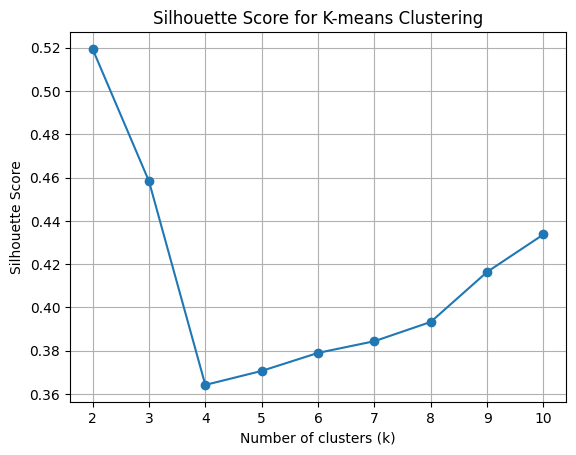

In [22]:


# Define a range of K values
k_values = range(2, 11)  # You can adjust the range as needed

# Initialize lists to store silhouette scores
silhouette_scores = []

# Fit KMeans and calculate silhouette score for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-means Clustering')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [22]:

# Define a range of K values
k_values = range(2, 10)  # You can adjust the range as needed

# Initialize lists to store silhouette scores
silhouette_scores = []

# Fit KMeans and calculate silhouette score for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Create interactive plot with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(k_values), y=silhouette_scores, mode='markers+lines', marker=dict(symbol='circle', size=10),
                         line=dict(color='blue', width=2)))

# Add annotation for optimal k
optimal_k = 2
fig.add_annotation(x=optimal_k, y=silhouette_scores[optimal_k - 2],
                   text='Optimal value of k',
                   arrowhead=2, showarrow=True,
                   arrowcolor='black', arrowwidth=2,
                   ax=50, ay=-50)

fig.update_layout(title='Silhouette Score for K-means Clustering',
                  xaxis_title='Number of clusters (k)',
                  yaxis_title='Silhouette Score',
                  hovermode='closest',
                  showlegend=False,
                  width=800,  # Specify width
                  height=500)  # Specify height

fig.show()


# Understanding through silhoutte diagram

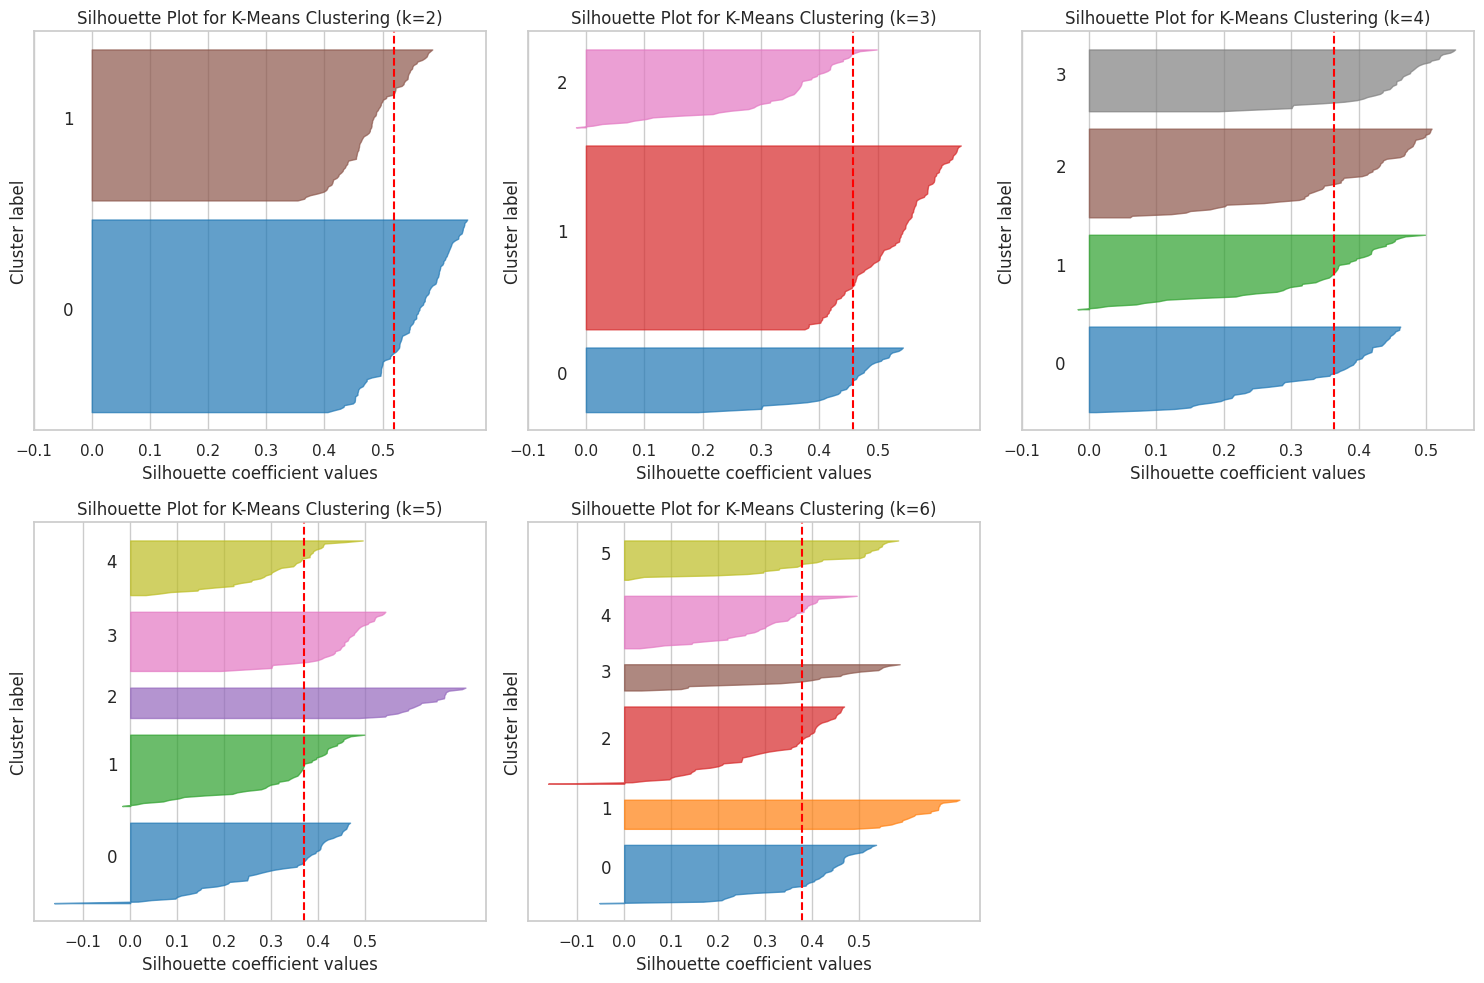

In [24]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples

# Calculate silhouette score and visualize silhouette diagram for k values from 1 to 6
plt.figure(figsize=(15, 10))

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=21)
    km_pred = km.fit_predict(df_scaled)

    silhouette_avg = silhouette_score(df_scaled, km_pred)
    silhouette_vals = silhouette_samples(df_scaled, km_pred)

    plt.subplot(2, 3, k-1)

    y_lower = 10
    for i in range(k):
        cluster_silhouette_vals = silhouette_vals[km_pred == i]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + cluster_silhouette_vals.shape[0]
        color = plt.cm.tab10(i / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * cluster_silhouette_vals.shape[0], str(i))
        y_lower = y_upper + 10

    plt.title('Silhouette Plot for K-Means Clustering (k={})'.format(k))
    plt.xlabel('Silhouette coefficient values')
    plt.ylabel('Cluster label')

    plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
    plt.yticks([])  # Clear the y-axis labels
    plt.xticks(np.arange(-0.1, 0.6, 0.1))

plt.tight_layout()
plt.show()



### Two cluster diagram looks the best from the above graph as the clusters are
1. similar sized

2. No negative values i.e no miss classification

3. Clusters are above the red line which is the average silhouette score.

In [25]:
# Define a range of K values
k_values = list(range(1, 11))  # Convert range to list

# Initialize lists to store inertia values
inertia_values = []

# Fit KMeans and calculate inertia for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia_values.append(kmeans.inertia_)

# Create interactive plot with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=k_values, y=inertia_values, mode='lines+markers', name='Inertia'))
fig.update_layout(title='Inertia for K-means Clustering (Elbow Method)',
                  xaxis_title='Number of clusters (k)',
                  yaxis_title='Inertia',
                  hovermode='closest',
                  width=800,  # Specify width
                  height=500)  # Specify height

# Add annotation for optimal k
optimal_k = 2  # Assuming k=2 is optimal in this case
fig.add_annotation(x=optimal_k, y=inertia_values[optimal_k - 1],
                   text='Optimal value of k',
                   arrowhead=2, showarrow=True,
                   arrowcolor='black', arrowwidth=2,
                   ax=50, ay=-50)

fig.show()


# Visualizing the clusters from K - Means clustering



*   Since we have 4 featrues we will first use PCA for dimentionality reduction and the visualize our clustering.
*   I will be using the first 3 principle components as it preserves 90% of variance in the dataset.



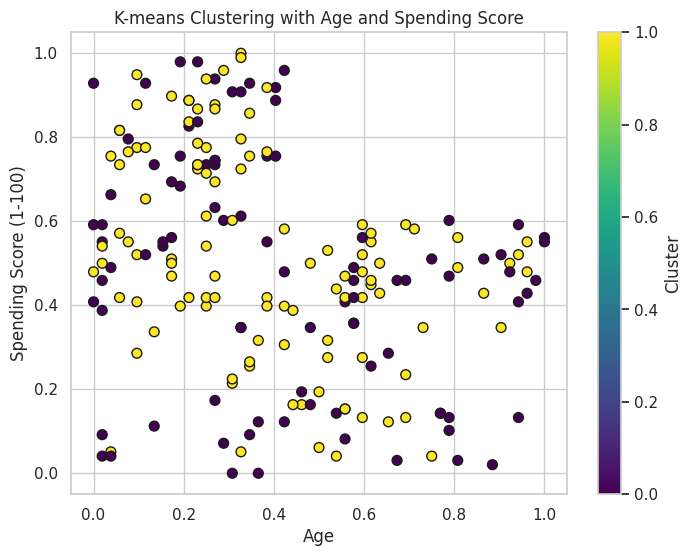

In [30]:
# Perform K-means clustering with optimal number of clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

# Select 'Age' and 'Spending Score' features from the dataset
age = df_scaled['Age']
spending_score = df_scaled['Spending Score (1-100)']

# Plot data points with clusters
plt.figure(figsize=(8, 6))
plt.scatter(age, spending_score, c=cluster_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('K-means Clustering with Age and Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

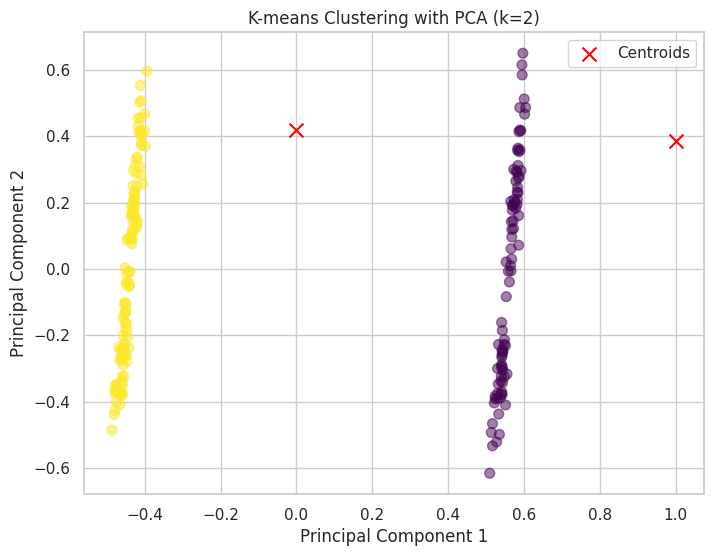

In [26]:

# Fit KMeans with optimal number of clusters (k = 2)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Visualize the clusters using the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with PCA (k=2)')
plt.legend()
plt.grid(True)
plt.show()

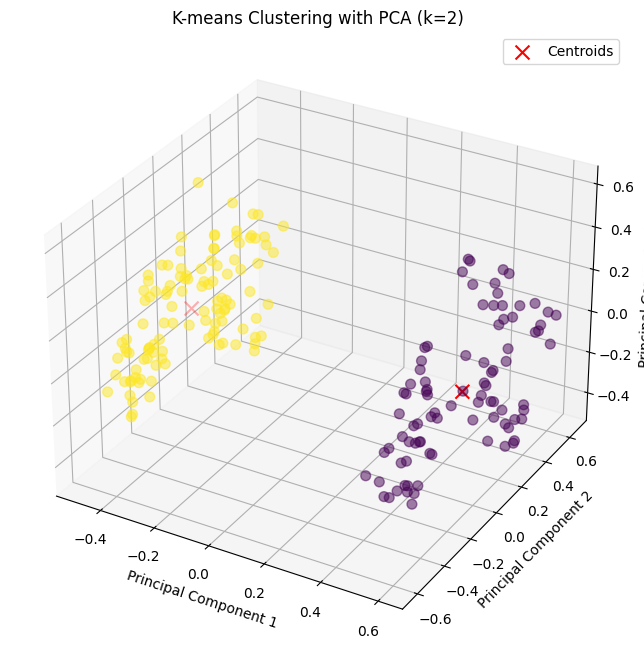

In [ ]:


# Fit KMeans with optimal number of clusters (k = 2)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

# Apply PCA to reduce dimensionality to 3 dimensions
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_scaled)

# Visualize the clusters using the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2],
                     c=cluster_labels, cmap='viridis', s=50, alpha=0.5)

# Plot centroids
centroids = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=100, label='Centroids')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('K-means Clustering with PCA (k=2)')
ax.legend()
plt.show()


In [32]:


# Fit KMeans with optimal number of clusters (k = 2)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

# Apply PCA to reduce dimensionality to 3 dimensions
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_scaled)

# Define cluster colors
cluster_colors = ['blue', 'green']  # Define colors for Cluster 1 and Cluster 2

# Create trace for data points
trace_data = go.Scatter3d(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    z=principal_components[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
    ),
    name='Data Points'
)

# Create trace for centroids
centroids = pca.transform(kmeans.cluster_centers_)
trace_centroids = go.Scatter3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        symbol='x',
        opacity=0.8
    ),
    name='Centroids'
)

# Define custom legend data
legend_data = [
    go.Scatter3d(
        x=[None],
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(size=0),
        name='Cluster 1',
        showlegend=True,
        marker_color=cluster_colors[0]  # Use the color for Cluster 1
    ),
    go.Scatter3d(
        x=[None],
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(size=0),
        name='Cluster 2',
        showlegend=True,
        marker_color=cluster_colors[1]  # Use the color for Cluster 2
    )
]

# Create layout
layout = go.Layout(
    title='K-means Clustering with PCA (k=2)',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    width=800,  # Specify width
    height=600,  # Specify height
    legend=dict(
        traceorder='normal'
    )
)

# Create figure
fig = go.Figure(data=[trace_data, trace_centroids] + legend_data, layout=layout)

# Show plot
fig.show()




*   The above 3D interactive visualization shows us how the clusters were present which are identified with K-means clustering.





In [33]:
pca = PCA()
pca.fit(df_scaled)

# Get the explained variance ratio for all principal components
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance_ratio = explained_variance_ratio.cumsum()[:3]
# Print the cumulative explained variance ratio for the first 5 components
print("Explained Variance Ratio for the First 5 Principal Components:")
print(explained_variance_ratio)
print("\n")
print("Cumulative Explained Variance Ratio for the First 5 Principal Components:")
print(cumulative_variance_ratio)

Explained Variance Ratio for the First 5 Principal Components:
[0.57076896 0.21404941 0.10928099 0.10590064]


Cumulative Explained Variance Ratio for the First 5 Principal Components:
[0.57076896 0.78481838 0.89409936]


### So with the 3 dimension we have preserved 90% of the data variance, and hence we are visualizing the clusters identified my K-means with this 3D interactive image.

# Clustering using Gaussian Mixture Models
Gaussian Mixture Models (GMMs) are probabilistic models that represent a dataset as a mixture of several Gaussian distributions. Unlike K-means, which assumes spherical clusters, GMMs can capture complex cluster shapes and account for the covariance between features. They are widely used in various fields such as image segmentation, anomaly detection, and clustering of high-dimensional data

## In Gaussian Mixture Models we will:

## - Indentify the optimal number of clusters uding the AIC and BIC curves.

## - Visualize those identified clusters

## - Generate new data, compare it with old data and perform classification task

In [18]:


# Define a range of K values (number of components)
n_components = list(range(1, 11))  # Convert range to list

# Fit Gaussian Mixture Models with different number of components
models = [GaussianMixture(n, random_state=42).fit(df_scaled) for n in n_components]

# Calculate AIC and BIC values
aic_values = [model.aic(df_scaled) for model in models]
bic_values = [model.bic(df_scaled) for model in models]

# Create interactive plot with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=n_components, y=aic_values, mode='lines+markers', name='AIC'))
fig.add_trace(go.Scatter(x=n_components, y=bic_values, mode='lines+markers', name='BIC'))

fig.update_layout(
    title='AIC and BIC Scores for Gaussian Mixture Models',
    xaxis_title='Number of Components',
    yaxis_title='Score',
    legend=dict(x=0, y=1.0, bgcolor='rgba(255, 255, 255, 0)', bordercolor='rgba(255, 255, 255, 0)'),
    width=800,
    height=600
)

fig.show()


In [ ]:
import plotly.graph_objects as go
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Fit Gaussian Mixture Model with optimal number of clusters
gmm = GaussianMixture(n_components=2, random_state=42)
cluster_labels = gmm.fit_predict(df_scaled)

# Apply PCA to reduce dimensionality to 3 dimensions
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_scaled)

# Define cluster colors
cluster_colors = ['red', 'blue']  # Define colors for Cluster 1 and Cluster 2

# Create trace for data points
trace_data = go.Scatter3d(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    z=principal_components[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Rainbow',  # Change color scheme here
        opacity=0.8
    ),
    name='Data Points'
)

# Define custom legend data
legend_data = [
    go.Scatter3d(
        x=[None],
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(size=0),
        name='Cluster 1',
        showlegend=True,
        marker_color=cluster_colors[0]  # Use the color for Cluster 1
    ),
    go.Scatter3d(
        x=[None],
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(size=0),
        name='Cluster 2',
        showlegend=True,
        marker_color=cluster_colors[1]  # Use the color for Cluster 2
    )
]

# Create layout
layout = go.Layout(
    title='GMM Clustering with PCA',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    width=800,  # Specify width
    height=600,  # Specify height
    legend=dict(
        traceorder='normal'
    )
)

# Create figure
fig = go.Figure(data=[trace_data] + legend_data, layout=layout)

# Show plot
fig.show()


# Clustering with DBSCAN
DBSCAN is a density-based clustering algorithm that groups together closely packed points in high-density regions. Unlike K-means and Gaussian Mixture Models, DBSCAN does not require a predetermined number of clusters and is robust to noise and outliers. It can identify arbitrarily shaped clusters and is suitable for datasets with varying densities.

## In DBSCAN we will:

## - Indentify the optimal number of clusters uding the DBSCAN algorithm

## - Visualize those identified clusters



In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
cluster_labels = dbscan.fit_predict(df_scaled)

# Define unique cluster labels (excluding noise points labeled as -1)
unique_labels = set(cluster_labels)
unique_labels.discard(-1)  # Remove noise label (-1) if present

# Define cluster colors
cluster_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

# Create trace for data points
trace_data = go.Scatter3d(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    z=principal_components[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Cividis',  # Change color scheme here
        opacity=0.8
    ),
    name='Data Points'
)

# Define custom legend data for clusters
legend_data = []
for label in unique_labels:
    legend_data.append(
        go.Scatter3d(
            x=[None],
            y=[None],
            z=[None],
            mode='markers',
            marker=dict(size=0),
            name=f'Cluster {label}',
            showlegend=True,
            marker_color=cluster_colors[label % len(cluster_colors)]  # Use a cyclic color scheme for clusters
        )
    )

# Create layout
layout = go.Layout(
    title='DBSCAN Clustering with PCA',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    width=800,  # Specify width
    height=600,  # Specify height
    legend=dict(
        traceorder='normal'
    )
)

# Create figure
fig = go.Figure(data=[trace_data] + legend_data, layout=layout)

# Show plot
fig.show()


# Classification Task


## - Generating new training data (1000 instances) with trained gaussian mixture models


In [28]:

# Fit Gaussian Mixture Model with optimal number of components
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(df_scaled)  # Assuming df_scaled is your data

# Generate new samples from the GMM
num_samples = 1000  # Number of new samples to generate
new_samples = gmm.sample(num_samples)
new_data = new_samples[0]  # Extract the generated samples

# Convert the numpy array to a pandas DataFrame
new_df = pd.DataFrame(new_data, columns=df_scaled.columns)

# Display the new DataFrame
print(new_df.head())


     Gender       Age  Annual Income (k$)  Spending Score (1-100)
0 -0.000234  0.043360            0.566054                0.350620
1  0.000543 -0.067322            0.572849                0.696079
2 -0.001913  0.592287            0.292810                0.462593
3  0.000314  0.989800            0.513359                0.269708
4 -0.000226  0.780293           -0.036598                0.490141


In [40]:
df_scaled.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,0.019231,0.000000,0.387755
1,0.0,0.057692,0.000000,0.816327
2,1.0,0.038462,0.008197,0.051020
3,1.0,0.096154,0.008197,0.775510
4,1.0,0.250000,0.016393,0.397959


# Comparing the Kernel Densities of original data and new data for a feature

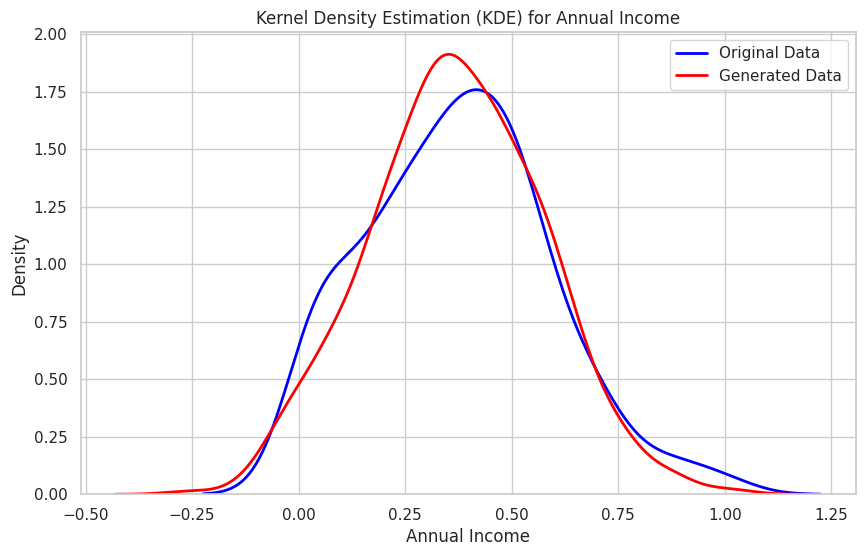

In [29]:

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Plot KDE for annual income in df_scaled
plt.figure(figsize=(10, 6))
sns.kdeplot(df_scaled['Annual Income (k$)'], color='blue', label='Original Data', linewidth=2)

# Plot KDE for annual income in new_df
sns.kdeplot(new_df['Annual Income (k$)'], color='red', label='Generated Data', linewidth=2)

# Set plot title and labels
plt.title('Kernel Density Estimation (KDE) for Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()


## Predicting the labels (associated clusters) from trained K-means on original dataset generated

In [30]:
new_cluster_labels = kmeans.predict(new_df)

# Add the predicted cluster labels to new_df
new_df['Cluster'] = new_cluster_labels

# Display the updated new_df
print(new_df)

       Gender       Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0   -0.000234  0.043360            0.566054                0.350620        0
1    0.000543 -0.067322            0.572849                0.696079        0
2   -0.001913  0.592287            0.292810                0.462593        0
3    0.000314  0.989800            0.513359                0.269708        0
4   -0.000226  0.780293           -0.036598                0.490141        0
..        ...       ...                 ...                     ...      ...
995  0.997918 -0.145733            0.560961                1.256499        1
996  0.999225  0.549304            0.333868                0.893346        1
997  1.000751  0.501444            0.602383               -0.041858        1
998  0.999680  0.534790            0.510826               -0.160412        1
999  0.999969 -0.069415            0.347275                0.727031        1

[1000 rows x 5 columns]


In [35]:
new_cluster_labels = kmeans.predict(df_scaled)

# Add the predicted cluster labels to new_df
df_scaled['Cluster'] = new_cluster_labels

# Display the updated new_df
print(df_scaled)

     Gender       Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0       0.0  0.019231            0.000000                0.387755        0
1       0.0  0.057692            0.000000                0.816327        0
2       1.0  0.038462            0.008197                0.051020        1
3       1.0  0.096154            0.008197                0.775510        1
4       1.0  0.250000            0.016393                0.397959        1
..      ...       ...                 ...                     ...      ...
195     1.0  0.326923            0.860656                0.795918        1
196     1.0  0.519231            0.909836                0.275510        1
197     0.0  0.269231            0.909836                0.744898        0
198     0.0  0.269231            1.000000                0.173469        0
199     0.0  0.230769            1.000000                0.836735        0

[200 rows x 5 columns]


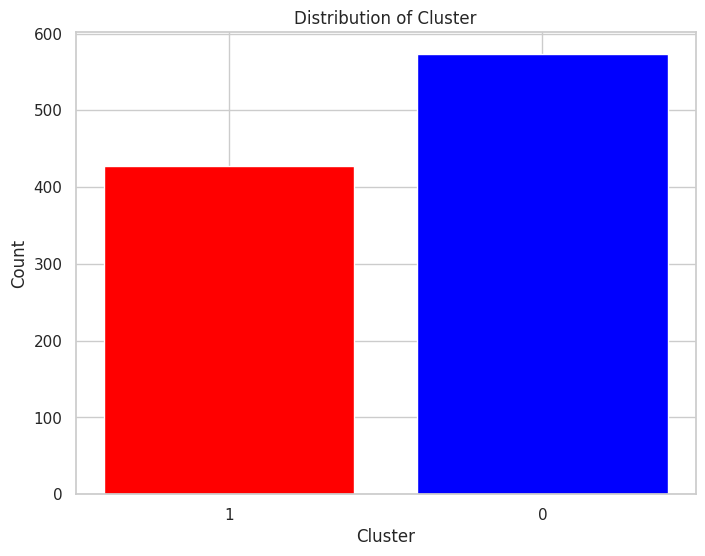

In [37]:

# Count the occurrences of each value in the 'Cluster' column
cluster_counts = new_df['Cluster'].value_counts()

# Plot a bar chart to visualize the distribution of 'Cluster'
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color=['blue', 'red'])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Cluster')
plt.xticks(cluster_counts.index, ['0', '1'])
plt.show()


## In the visualizations below we will indentify what are the traits of the customers in these clusters



*   When it comes to annual income the customers in cluster 1 has greater aannual income than people in cluster 2.
*   Entire cluster 1 is women and entire cluster 2 is men



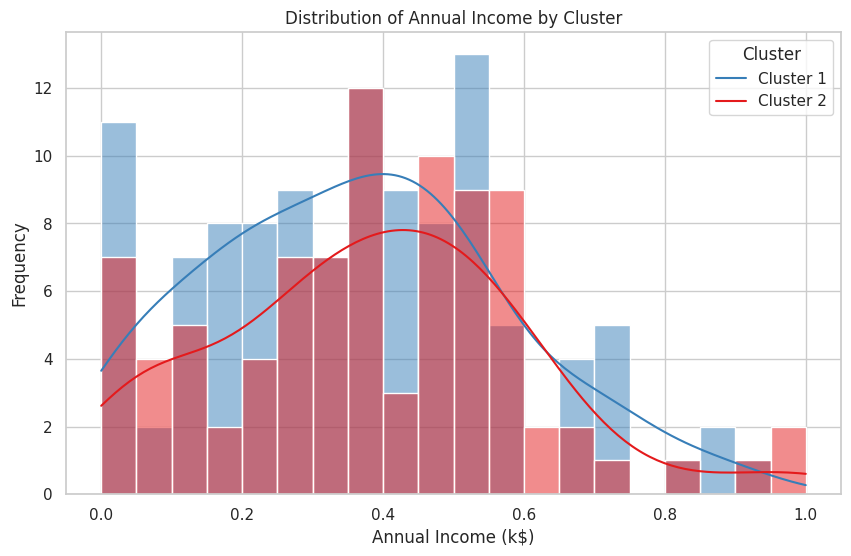

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot
sns.set_style("whitegrid")

# Plot distribution of Annual Income for each cluster
plt.figure(figsize=(10, 6))
sns.histplot(data=df_scaled, x='Annual Income (k$)', hue='Cluster', palette='Set1', bins=20, kde=True)
plt.title('Distribution of Annual Income by Cluster')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.legend(title='Cluster', labels=['Cluster 1', 'Cluster 2'])

plt.grid(True)
plt.grid(True)
plt.show()


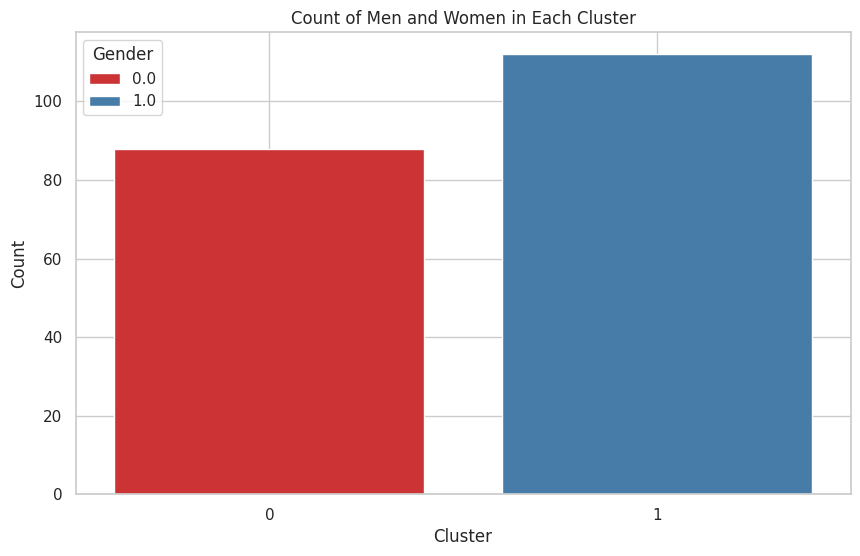

In [50]:
# Set the style of the plot
sns.set_style("whitegrid")

# Plot count of men and women in each cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df_scaled, x='Cluster', hue='Gender', palette='Set1')
plt.title('Count of Men and Women in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Set legends
plt.legend(title='Gender')

plt.grid(True)
plt.show()

# Performing classification of these new customers by Logistic regression

In [38]:

# Separate features and target variable
X = df_scaled.drop('Cluster', axis=1)
y = df_scaled['Cluster']


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



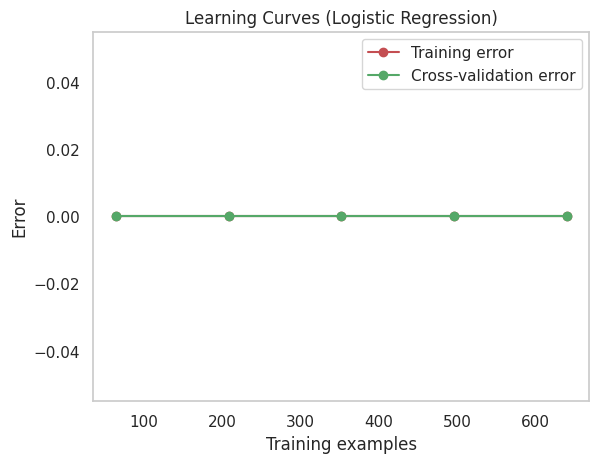

In [49]:

# Define function for plotting learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

# Separate features and target variable
X = new_df.drop('Cluster', axis=1)
y = new_df['Cluster']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Plot learning curve
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(model, title, X_train, y_train, cv=5)
plt.show()


In [51]:


# Define function for computing learning curve
def compute_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    return train_sizes, train_scores_mean, test_scores_mean

# Separate features and target variable
X = new_df.drop('Cluster', axis=1)
y = new_df['Cluster']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Compute learning curve
train_sizes, train_errors, test_errors = compute_learning_curve(model, X_train, y_train, cv=5)

# Create interactive 3D plot
fig = go.Figure()

# Add training error trace
fig.add_trace(go.Scatter3d(x=train_sizes, y=train_errors, z=test_errors, mode='markers',
                           marker=dict(color='red', size=5), name='Training Error'))

# Add cross-validation error trace
fig.add_trace(go.Scatter3d(x=train_sizes, y=test_errors, z=train_errors, mode='markers',
                           marker=dict(color='blue', size=5), name='Cross-Validation Error'))

# Update layout
fig.update_layout(scene=dict(xaxis_title='Training Examples',
                             yaxis_title='Error', zaxis_title='Error'),
                  title='Learning Curve (Logistic Regression)',
                  margin=dict(l=0, r=0, t=30, b=0))

# Show plot
fig.show()
